In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7644106730251347386, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9582097693334014359
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14736146941132633228
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15864515789
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5928492277044524272
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [22]:
def relu(x): 
    return Activation('relu')(x)
def dropout(x, p): 
    return Dropout(p)(x) if p else x
def bn(x): 
    return BatchNormalization()(x)  # Keras 2
def relu_bn(x): 
    return relu(bn(x))
def concat(xs): 
    return concatenate(xs)  # Keras 2

In [35]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential
from keras.layers import *
import keras
from keras.applications.resnet50 import ResNet50, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model 
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import constraints 
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.constraints import max_norm
import keras.backend as K
import tempfile  
import logging
from IPython.display import SVG
#import mkl
import matplotlib.pyplot as plt

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

"""
# Create simple model
from keras.layers import Conv2D, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, 5, activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(128, 5, activation='relu', padding='same'))
model.add(Conv2D(1, 5, activation='sigmoid', padding='same'))
model.add(Reshape((128, 128)))
          
model.compile(Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])     
"""


from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import History


def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, (sz, sz), padding='same', strides=(stride,stride), kernel_regularizer=l2(wd), kernel_initializer='lecun_uniform')(x)
    
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)


def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, (3, 3), padding='same', input_shape=(None,r*2,c*2,ch), strides=(2,2), kernel_initializer='lecun_uniform', kernel_regularizer=l2(wd))(x)
#Deconv2D(ch, (3, 3), input_shape=(r*2, c*2, ch), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(wd)) (x)


#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x


nb_classes = 1
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0): #number of filters changed from 16
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((512,512))(x)
    if nb_classes == 1:
        return Activation('sigmoid')(x)
    else:
        return Activation('softmax')(x)
    


In [36]:
def reverse(a): return list(reversed(a))

In [38]:
segm_bs= 5 #segmenter number of slices to be generated should be equal to batch size?
#number_segments = 3
n_classes = 1
segm_sz = (512,512)
input_shape = segm_sz+(3,)
lrate= 1e-4
dcay=1-(lrate/2)
db = 6 #number of dense block
dblayers= [4,5,7,10, 12, 15] #dense layers per dense block
drpout=0.2
n_filters=32 #48
def dropout(x, p): 
    return Dropout(p)(x) if p else x
img_input = Input(shape=input_shape)

x = create_tiramisu(n_classes, img_input, nb_dense_block=db,nb_filter=n_filters,
                    nb_layers_per_block=dblayers, p=drpout, wd=1e-4)  #4,5,7,10 #p=.5 #wd=1e-4
x.shape

model = Model(img_input, x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_484 (Conv2D)             (None, 512, 512, 32) 896         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_469 (BatchN (None, 512, 512, 32) 128         conv2d_484[0][0]                 
__________________________________________________________________________________________________
activation_472 (Activation)     (None, 512, 512, 32) 0           batch_normalization_469[0][0]    
__________________________________________________________________________________________________
conv2d_485

In [85]:
from glob import glob
import os

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])

print (len(train_img_paths))
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print(val_img_paths[:5])

['train/10729_sat.jpg', 'train/51187_sat.jpg', 'train/52299_sat.jpg', 'train/4962_sat.jpg', 'train/13549_sat.jpg', 'train/15363_sat.jpg', 'train/38456_sat.jpg', 'train/50517_sat.jpg', 'train/32252_sat.jpg', 'train/12993_sat.jpg']
['train/12895_msk.png', 'train/23379_msk.png', 'train/19799_msk.png', 'train/andy647_msk.png', 'train/2575_msk.png', 'train/50807_msk.png', 'train/41694_msk.png', 'train/9457_msk.png', 'train/alex141_msk.png', 'train/34365_msk.png']
12897
['val/70036_sat.jpg', 'val/75729_sat.jpg', 'val/78249_sat.jpg', 'val/76288_sat.jpg', 'val/71029_sat.jpg']


In [2]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

Using TensorFlow backend.


ModuleNotFoundError: No module named 'crfrnn_layer'

In [7]:
model = build_fc_densenet((512,512,3), 2, preset_model='FC-DenseNet56')
model.summary()

ValueError: Convolution expects input with rank 4, got 1

In [97]:
%matplotlib inline
import collections
import mxnet as mx # used version '1.0.0' at time of writing
from mxnet.gluon.data import dataset
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
def positional_augmentation(joint):
    # Random crop
    crop_height = 200
    crop_width = 200
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    joint = mx.nd.array(joint)
    aug_joint = aug(joint)
    # Add more translation/scale/rotation augmentations here...
    return aug_joint.asnumpy()


def horizontal_augmentation(joint):

    aug = mx.image.HorizontalFlipAug(p = 1)
    joint = mx.nd.array(joint)
    aug_joint = aug(joint)
    # Add more translation/scale/rotation augmentations here...
    return aug_joint.asnumpy()


def overall_augmentation(base):
    aug = mx.image.ColorJitterAug(brightness = .7, contrast = .7, saturation = .7)
    base = mx.nd.array(base)
    aug_base = aug(base)
    # Add more color augmentations here...
    aug_base = aug_base.astype('int')
    return aug_base.asnumpy()
    

def horizontal_transform(base, mask):
    ### Convert types
    base = base.astype('float')
    mask = mask.astype('float')
  

    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = np.dstack((base, mask.reshape((512,512,1))))
    #joint = mx.nd.concat(base, mask, dim=2)
    #print (joint.shape)

    ### Augmentation Part 1: positional
    aug_joint = horizontal_augmentation(joint)   
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    aug_base = resize(aug_base, (512,512), mode='constant', preserve_range=True).astype('int')
    aug_mask = resize(aug_mask, (512,512), mode='constant', preserve_range=True).reshape((512,512)).astype('int')
    return aug_base, aug_mask

def size_transform(base, mask):
    ### Convert types
    base = base.astype('float')
    mask = mask.astype('float')
  

    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = np.dstack((base, mask.reshape((512,512,1))))
    #joint = mx.nd.concat(base, mask, dim=2)
    #print (joint.shape)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)   
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    aug_base = resize(aug_base, (512,512), mode='constant', preserve_range=True).astype('int')
    aug_mask = resize(aug_mask, (512,512), mode='constant', preserve_range=True).reshape((512,512)).astype('int')
    return aug_base, aug_mask

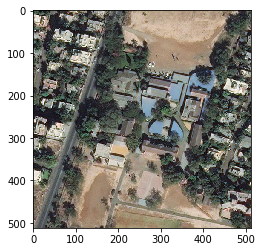

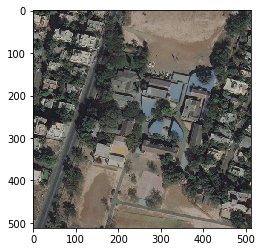

In [113]:
import matplotlib.pyplot as plt
original = imread(train_img_paths[1])
img_id = get_img_id(train_img_paths[1])
mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        

mask = imread(mask_path, as_gray=True)

aug = overall_augmentation(original.astype('float'))

plt.imshow(original)
plt.show()

plt.imshow(aug)
plt.show()

(512, 512, 3) (512, 512)


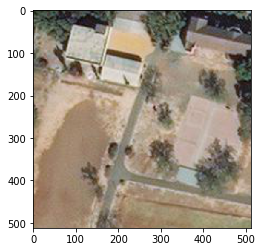

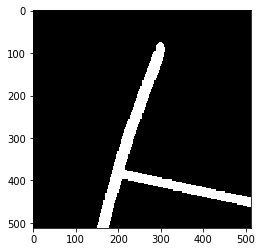

In [119]:
joint1, joint2 = size_transform(original,mask)
print (joint1.shape, joint2.shape)
plt.imshow(joint1)
plt.show()
plt.imshow(joint2, cmap='gray')
plt.show()

In [101]:
from random import shuffle
import cv2

shuffle(train_img_paths)

for i in range(len(train_img_paths[:1000])): #take 1000 random pics (after shuffling)
    path = 'train'
    original = imread(train_img_paths[i])
    img_id = get_img_id(train_img_paths[i])
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    mask = imread(mask_path, as_gray=True)
    joint1, joint2 = horizontal_transform(original,mask)
    
    cv2.imwrite(os.path.join(path , 'andy'+ str(i) + '_sat.jpg'), joint1) 
    cv2.imwrite(os.path.join(path , 'andy' + str(i) + '_msk.png'), joint2)
    
    joint1, joint2 = size_transform(original,mask)

    cv2.imwrite(os.path.join(path , 'alex'+ str(i) + '_sat.jpg'),joint1)
    cv2.imwrite(os.path.join(path , 'alex' + str(i) + '_msk.png'),joint2)

KeyboardInterrupt: 

In [87]:
#compute average image

average = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    average = np.add(average, img)
avg = average/12897

In [88]:
#compute standard deviation image

sd = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    a = np.subtract(img, avg)
    a = np.square(a)
    sd = np.add(sd, a)
sd = sd/12897
sd = np.sqrt(sd)


In [89]:
print (sd)

[[[ 42.99704684  33.98640093  32.4977063 ]
  [ 41.63211594  32.6527684   31.70141475]
  [ 41.12481237  32.07776145  31.77947546]
  ..., 
  [ 41.22133087  32.00790021  31.55333733]
  [ 41.99337556  32.7951113   31.60935344]
  [ 43.22281324  34.14747646  32.38663206]]

 [[ 41.80008903  32.74017103  31.72960271]
  [ 40.39770231  31.409122    31.29624764]
  [ 39.75707192  30.99667767  31.8529746 ]
  ..., 
  [ 39.79874691  30.83899114  31.48723476]
  [ 40.58725315  31.38941027  31.04467163]
  [ 41.86827366  32.67919446  31.47160003]]

 [[ 40.99986697  31.91034739  31.51449911]
  [ 39.59382349  30.80887505  31.58612414]
  [ 39.11021719  30.9303867   32.96392074]
  ..., 
  [ 39.25264222  30.85196359  32.65039949]
  [ 39.83705019  30.84453196  31.38168552]
  [ 41.13316139  31.91713398  31.35398568]]

 ..., 
 [[ 41.18024125  31.88023056  31.04653222]
  [ 39.84881029  30.83478874  31.12809809]
  [ 39.34046493  30.96899838  32.54354723]
  ..., 
  [ 38.91449741  30.56414351  32.44269266]
  [ 39.47

In [93]:
model = unet() #create new unet model
model.load_weights('unet.hdf5') #load model with pre-saved weights

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [91]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            img = np.divide((img - avg),sd) #0 mean, 1 var
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []


In [92]:
from sklearn.model_selection import train_test_split
import keras.callbacks
BATCHSIZE = 35 #biggest you can make it 

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.05)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

filepath="unet.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs= 10, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks = callbacks_list 
)

Epoch 1/10
351/351 [==============================] - 761s 2s/step - loss: 0.3104 - dice_coef: 0.7402 - val_loss: 0.3148 - val_dice_coef: 0.7366
Epoch 2/10
351/351 [==============================] - 744s 2s/step - loss: 0.2874 - dice_coef: 0.7597 - val_loss: 0.3218 - val_dice_coef: 0.7304
Epoch 3/10
351/351 [==============================] - 739s 2s/step - loss: 0.2733 - dice_coef: 0.7719 - val_loss: 0.3376 - val_dice_coef: 0.7175
Epoch 4/10
351/351 [==============================] - 726s 2s/step - loss: 0.2606 - dice_coef: 0.7827 - val_loss: 0.3321 - val_dice_coef: 0.7227
Epoch 5/10
351/351 [==============================] - 724s 2s/step - loss: 0.2532 - dice_coef: 0.7890 - val_loss: 0.3232 - val_dice_coef: 0.7307
Epoch 6/10
 29/351 [=>............................] - ETA: 9:31 - loss: 0.2463 - dice_coef: 0.7942

KeyboardInterrupt: 

In [94]:
import numpy as np
import pandas as pd

# Create submission DataFrame
def create_submission(csv_name, predictions_gen):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> generator that yields a pair of id, prediction
    """
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(val_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        #print (np.count_nonzero(pred == 1))
        encodings.append(rle_encoding(pred))
        
    sub['EncodedPixels'] = encodings
    sub['ImageId'] = ids
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [95]:

def generate_pixel_by_pixel_predictions_generator(val_paths):
    for img_path in val_paths:        
        img = imread(img_path)
        img = resize(img, (512, 512), preserve_range=True) 
        img = np.divide((img - avg),sd) #0 mean, 1 var
        y = model.predict(img.reshape(1,512,512,3))  
        y = (y >= 0.5).astype(float) #IMPORTANT- need this or you won't have 0 or 1 (because outputs are probabilities!!)
        yield get_img_id(img_path), y.reshape(512, 512)

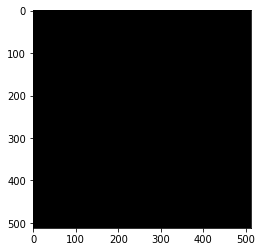

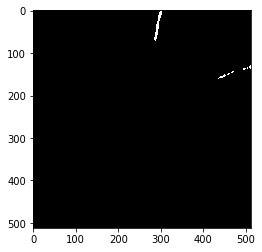

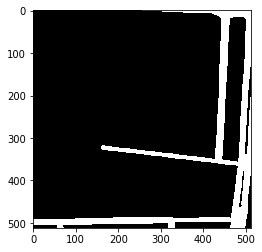

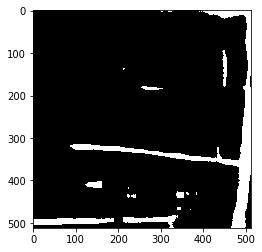

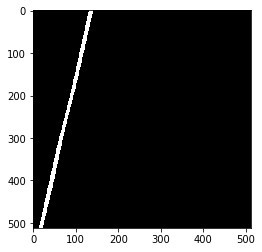

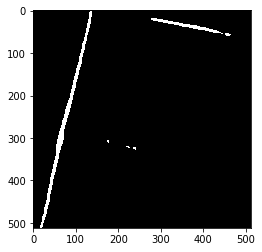

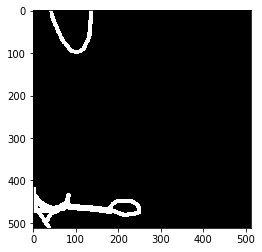

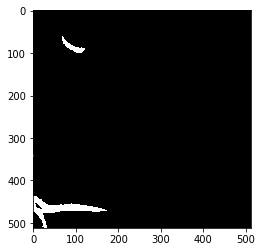

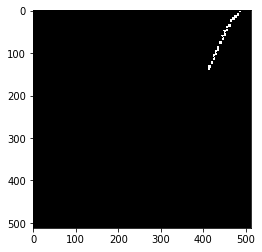

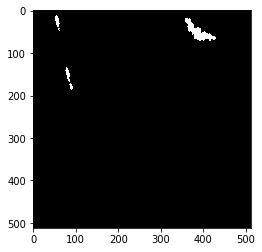

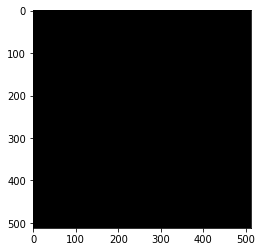

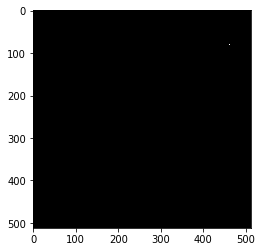

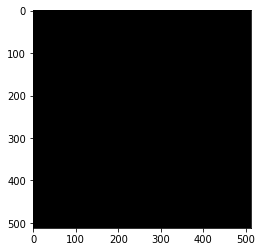

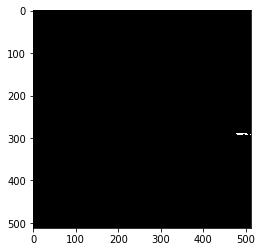

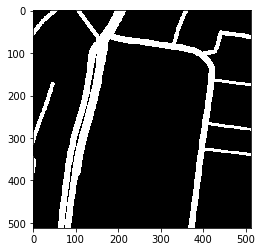

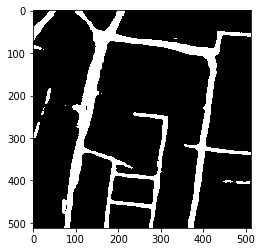

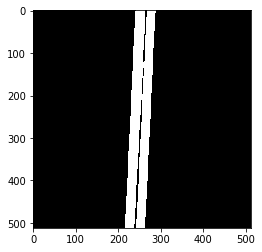

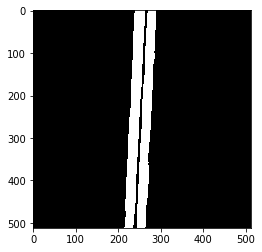

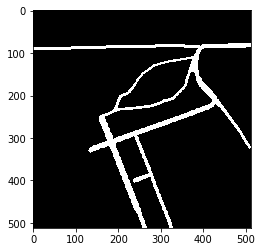

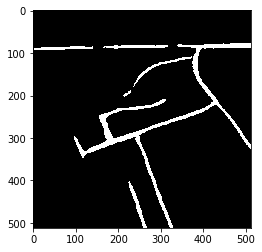

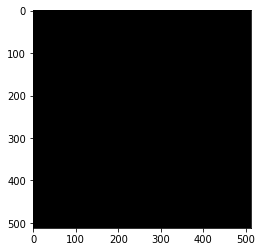

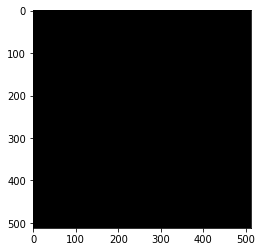

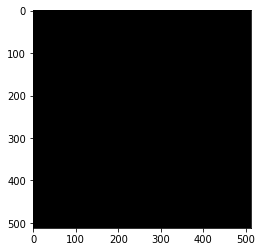

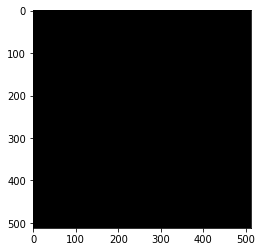

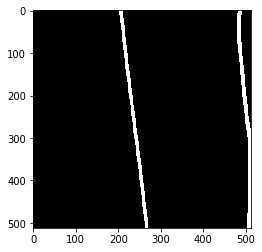

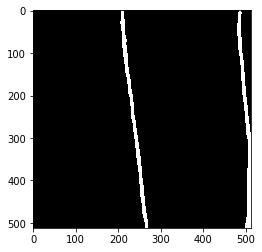

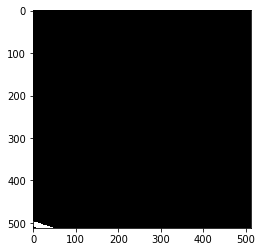

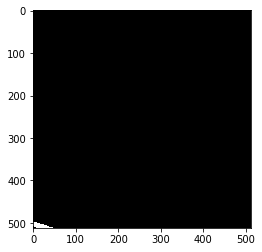

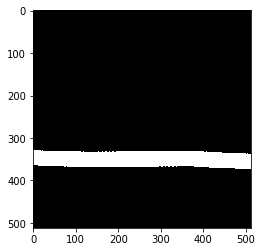

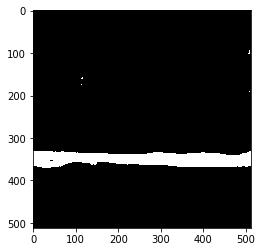

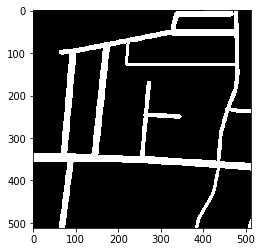

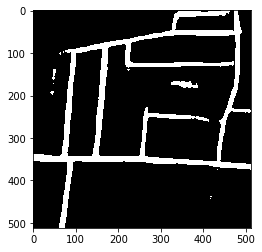

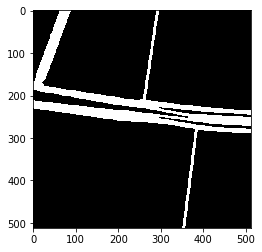

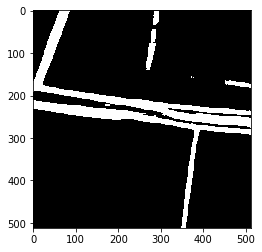

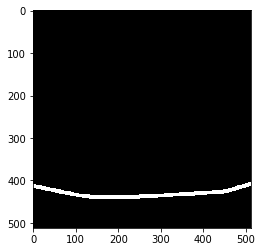

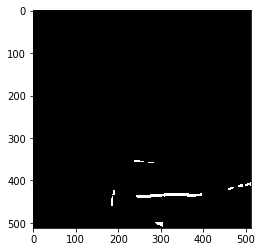

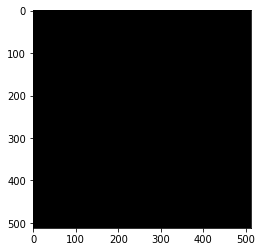

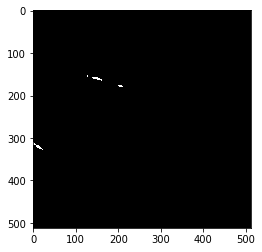

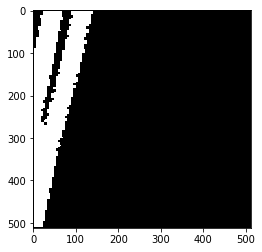

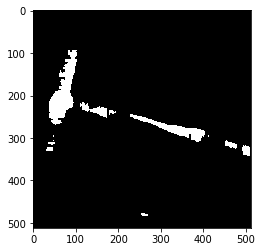

' \ntic = time.time()\ncreate_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))\ntoc = time.time()\nprint(toc - tic)\n'

In [96]:
import time
import matplotlib.pyplot as plt
path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')
train_img_paths = glob(glob_train_imgs)
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)


#first_img, first_mask = next(ig)

img_size = (512,512)
for i in range(30,50): 
    
    img_id = get_img_id(train_img_paths[i])
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
           
    original = imread(train_img_paths[i]) 
    img = np.divide(original- avg,sd)
    mask = rgb2gray(imread(mask_path))
    img = resize(img, img_size, preserve_range=True)
    mask = resize(mask, img_size, mode='constant', preserve_range=True)    
    mask = (mask >= 0.5).astype(float)
    
    plt.imshow(mask, cmap='gray')
    plt.show()
    
    y = model.predict(img.reshape(1,512,512,3)) 
    y = (y.reshape(512,512) >= 0.5).astype(float)
    
    plt.imshow(y, cmap='gray')
    plt.show()
""" 
tic = time.time()
create_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))
toc = time.time()
print(toc - tic)
"""


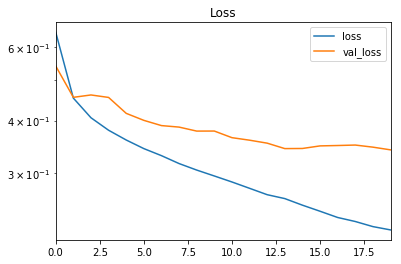

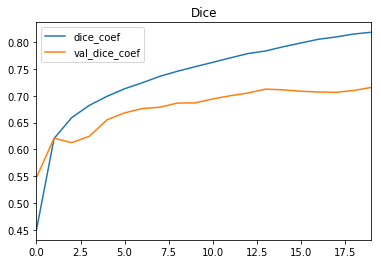

In [20]:
import pandas as pd
%matplotlib inline

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")
